In [133]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from src.utils import get_wandb_summaries
import numpy as np
from src.utils import download_table
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from statsmodels.stats.contingency_tables import mcnemar
import itertools

In [2]:
FLU_RUNS_ALL = {
    "Our Model":"z0nbehr0", 
    "XGBoost":"7r8nxjo5", 
    "CNN":"ko9zy18b",
}
all_predictions = {}
for k,v in FLU_RUNS_ALL.items():
    all_predictions[k] = download_table(v,"test_predictions")

In [182]:
def predictions_at_sensitivity(preds,labels, sensitivity=0.80):
    fpr,tpr, thresholds = roc_curve(labels,preds)
    i = np.argmax(tpr>sensitivity)
    threshold = thresholds[i]
    return preds.values>threshold

def predictions_at_max_sens_spec(preds,labels):
    fpr,tpr, thresholds = roc_curve(labels,preds)
    spec = 1-fpr

    i  = np.argmax(tpr+spec)
    print(f"Max sens+spec: {}")
    threshold = thresholds[i]
    return preds.values>threshold

In [123]:
def add_true_positives(thresholded_preds,labels,n_to_add=1):
    false_negatives = np.nonzero((thresholded_preds == 0) & (labels==1))[0]
    print(false_negatives)
    to_flip = np.random.choice(false_negatives,size=(n_to_add,), replace=False)
    to_return = np.copy(thresholded_preds)
    to_return[to_flip] = 1
    return to_return


def get_more_right(thresholded_preds,labels,n_to_add=1):
    wrong = np.nonzero(thresholded_preds !=labels)[0]
    to_flip = np.random.choice(wrong,size=(n_to_add,), replace=False)
    to_return = np.copy(thresholded_preds)
    to_return[to_flip] = ~to_return[to_flip]
    return to_return

In [124]:
preds = predictions_at_sensitivity(all_predictions["Our Model"]["pred"], all_predictions["Our Model"]["label"])
accuracy_score(all_predictions["Our Model"]["label"].values,preds)

216 2114


0.8069035691922355

In [125]:
five_more_right = get_more_right(preds,all_predictions["Our Model"]["label"].values,1000)
accuracy_score(all_predictions["Our Model"]["label"].values,five_more_right)

0.8156004313643638

In [126]:
def get_contingency_table(p1,p2,labels):
    tab = np.zeros((2,2))
    tab[0,0] = ((p1 == labels)&(p2==labels)).sum()
    tab[0,1] = ((p1 != labels)&(p2==labels)).sum()
    tab[1,0] = ((p1 == labels)&(p2!=labels)).sum()
    tab[1,1] = ((p1 != labels)&(p2!=labels)).sum()
    return tab

In [127]:
index = ["participant_id","date"]
merged = all_predictions["Our Model"].set_index(index).join(all_predictions["CNN"].set_index(index),lsuffix="_ours",rsuffix="_cnn").dropna()

In [128]:
merged

,,label_ours,pred_ours,label_cnn,pred_cnn
participant_id,date,,,,
003f2860b77483ed598b9a915781670b,2020-03-27 23:59:59.999000,0,5.239357e-07,0,7.788170e-05
00ec156b17dcf1e074fb54a704710f01,2020-02-21 23:59:59.999000,0,1.052754e-05,0,5.063375e-05
016f167a63e858daae217a425aecc23b,2020-02-29 23:59:59.999000,0,2.461331e-06,0,8.931685e-05
0233fa5f78ac2628d98d8ed8e7a8920c,2020-02-20 23:59:59.999000,0,2.639837e-06,0,3.337142e-07
02714922ba62349ebf7aea8cfc46d3ac,2020-03-21 23:59:59.999000,0,8.728128e-05,0,1.928608e-03
...,...,...,...,...,...
fdfe93f35a009fe7b9772b52c462bf12,2020-03-14 23:59:59.999000,0,5.427657e-07,0,3.507546e-05
fe8a5ad6f54650c8fe7c4ef0a822d1ed,2020-03-19 23:59:59.999000,0,3.127789e-06,0,2.547369e-06
feabb547228dd93259fb5646455d6c4c,2020-02-21 23:59:59.999000,0,8.493297e-06,0,4.056186e-05


In [174]:
ps = []
x = []
accs = []
labels = merged["label_ours"].values
p1 = predictions_at_sensitivity(merged["pred_ours"], labels, sensitivity=0.6) 
base_p2 = predictions_at_sensitivity(merged["pred_ours"], labels, sensitivity=0.6) 

for i in np.arange(0,100,1):
    improved_p2 = get_more_right(base_p2,labels,i)
    tab = get_contingency_table(p1,improved_p2,labels)
    result = mcnemar(tab, exact=True)
    accs.append(accuracy_score(labels,improved_p2))
    ps.append(result.pvalue)
    x.append(i)

76 2114
76 2114


In [175]:
get_contingency_table(p1,base_p2,labels)

array([[104510.,      0.],
       [     0.,  10474.]])

In [176]:
get_contingency_table(p1,improved_p2,labels)

array([[1.0451e+05, 9.9000e+01],
       [0.0000e+00, 1.0375e+04]])

Text(0.5, 1.0, 'Comparison of Our Model v.s. CNN at 0.8 Sensitivity')

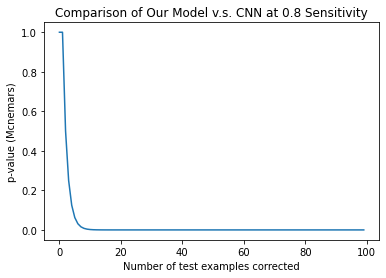

In [177]:
plt.plot(x,ps)
plt.xlabel("Number of test examples corrected")
plt.ylabel("p-value (Mcnemars)")
plt.title("Comparison of Our Model v.s. CNN at 0.8 Sensitivity")

In [134]:
precision_recall_fscore_support(p1,labels)

(array([0.8453193 , 0.79545455]),
 array([0.99990738, 0.00196475]),
 array([0.91613785, 0.00391981]),
 array([97170, 17814]))

In [135]:
precision_recall_fscore_support(base_p2,labels)

(array([0.80690795, 0.79545455]),
 array([0.99990297, 0.00157452]),
 array([0.89309805, 0.00314282]),
 array([92755, 22229]))

In [180]:
ps = []
xs = []
for x in np.linspace(0,1,20):
    p1 = predictions_at_sensitivity(merged["pred_ours"], labels, sensitivity=x) 
    p2 = predictions_at_sensitivity(merged["pred_cnn"], labels, sensitivity=x)
    tab = get_contingency_table(p1,p2,labels)
    result = mcnemar(tab, exact=True)
    ps.append(result.pvalue)
    xs.append(x)


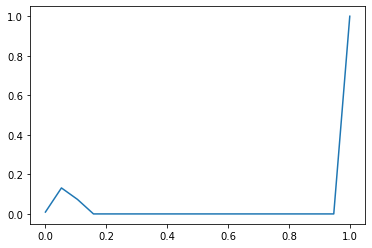

In [181]:
plt.plot(xs,ps)

CNN: (array([0.8453193 , 0.79545455]), array([0.99990738, 0.00196475]), array([0.91613785, 0.00391981]), array([97170, 17814]))
Ours: (array([0.85272316, 0.75      ]), array([0.99988778, 0.00194564]), array([0.92046036, 0.00388121]), array([98023, 16961]))


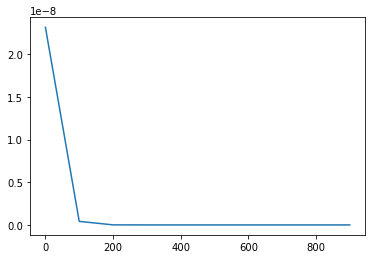

In [187]:
ps = []
x = []
accs = []
labels = merged["label_ours"].values
p1 = predictions_at_max_sens_spec(merged["pred_cnn"], labels) 
base_p2 = predictions_at_max_sens_spec(merged["pred_ours"], labels) 

for i in np.arange(0,1000,100):
    improved_p2 = get_more_right(base_p2,labels,i)
    tab = get_contingency_table(p1,improved_p2,labels)
    result = mcnemar(tab, exact=True)
    accs.append(accuracy_score(labels,improved_p2))
    ps.append(result.pvalue)
    x.append(i)

plt.plot(x,ps)


print("CNN:",precision_recall_fscore_support(p1,labels))
print("Ours:",precision_recall_fscore_support(base_p2,labels))